In [1]:
# Standard Library Imports
import os
import itertools
import warnings
warnings.filterwarnings("ignore")

# Data Handling and Numerical Operations
import numpy as np
import pandas as pd
import kagglehub as kh

# Plotting Libraries
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import seaborn as sns
!pip install visualkeras
import visualkeras as vk

# Model Building and Preprocessing
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Dropout, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import get_file
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint


# Model Evaluation and Metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, classification_report, roc_curve, auc, confusion_matrix


ddsm_path = kh.dataset_download("awsaf49/cbis-ddsm-breast-cancer-image-dataset")
print(ddsm_path)

/kaggle/input/cbis-ddsm-breast-cancer-image-dataset


# Data Preperation

In [2]:
df_meta = pd.read_csv(ddsm_path+'/csv/meta.csv')
df_meta.head()

,SeriesInstanceUID,StudyInstanceUID,Modality,SeriesDescription,BodyPartExamined,SeriesNumber,Collection,Visibility,ImageCount
0,1.3.6.1.4.1.9590.100.1.2.117041576511324414842...,1.3.6.1.4.1.9590.100.1.2.229361142710768138411...,MG,ROI mask images,BREAST,1,CBIS-DDSM,1,2
1,1.3.6.1.4.1.9590.100.1.2.438738396107617880132...,1.3.6.1.4.1.9590.100.1.2.195593486612988388325...,MG,ROI mask images,BREAST,1,CBIS-DDSM,1,2
2,1.3.6.1.4.1.9590.100.1.2.767416741131676463382...,1.3.6.1.4.1.9590.100.1.2.257901172612530623323...,MG,ROI mask images,BREAST,1,CBIS-DDSM,1,2
3,1.3.6.1.4.1.9590.100.1.2.296931352612305599800...,1.3.6.1.4.1.9590.100.1.2.109468616710242115222...,MG,ROI mask images,BREAST,1,CBIS-DDSM,1,2
4,1.3.6.1.4.1.9590.100.1.2.436657670120353100077...,1.3.6.1.4.1.9590.100.1.2.380627129513562450304...,MG,ROI mask images,BREAST,1,CBIS-DDSM,1,2


In [3]:
# load dicom info file
df_dicom = pd.read_csv(ddsm_path+'/csv/dicom_info.csv')
df_dicom.head()

,file_path,image_path,AccessionNumber,BitsAllocated,BitsStored,BodyPartExamined,Columns,ContentDate,ContentTime,ConversionType,...,SecondaryCaptureDeviceManufacturerModelName,SeriesDescription,SeriesInstanceUID,SeriesNumber,SmallestImagePixelValue,SpecificCharacterSet,StudyDate,StudyID,StudyInstanceUID,StudyTime
0,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.12930...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.129308...,NaN,16,16,BREAST,351,20160426,131732.685,WSD,...,MATLAB,cropped images,1.3.6.1.4.1.9590.100.1.2.129308726812851964007...,1,23078,ISO_IR 100,20160720.0,DDSM,1.3.6.1.4.1.9590.100.1.2.271867287611061855725...,214951.0
1,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.24838...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.248386...,NaN,16,16,BREAST,3526,20160426,143829.101,WSD,...,MATLAB,full mammogram images,1.3.6.1.4.1.9590.100.1.2.248386742010678582309...,1,0,ISO_IR 100,20160720.0,DDSM,1.3.6.1.4.1.9590.100.1.2.161516517311681906612...,193426.0
2,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.26721...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.267213...,NaN,16,16,BREAST,1546,20160503,111956.298,WSD,...,MATLAB,full mammogram images,1.3.6.1.4.1.9590.100.1.2.267213171011171858918...,1,0,ISO_IR 100,20160807.0,DDSM,1.3.6.1.4.1.9590.100.1.2.291043622711253836701...,161814.0
3,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.38118...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.381187...,NaN,16,16,BREAST,97,20160503,115347.770,WSD,...,MATLAB,cropped images,1.3.6.1.4.1.9590.100.1.2.381187369611524586537...,1,32298,ISO_IR 100,20170829.0,DDSM,1.3.6.1.4.1.9590.100.1.2.335006093711888937440...,180109.0
4,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.38118...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.381187...,NaN,8,8,Left Breast,3104,20160503,115347.770,WSD,...,MATLAB,NaN,1.3.6.1.4.1.9590.100.1.2.381187369611524586537...,1,0,ISO_IR 100,NaN,DDSM,1.3.6.1.4.1.9590.100.1.2.335006093711888937440...,NaN


In [4]:
# check image types in dataset
df_dicom.SeriesDescription.unique()

array(['cropped images', 'full mammogram images', nan, 'ROI mask images'],
      dtype=object)

In [5]:
# check image path in dataset
# cropped images
cropped_images = df_dicom[df_dicom.SeriesDescription=='cropped images'].image_path
print(cropped_images.iloc[0])

CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.129308726812851964007517874181459556304/1-172.jpg


In [6]:
#full mammogram images
full_images = df_dicom[df_dicom.SeriesDescription=='full mammogram images'].image_path
print(full_images.iloc[0])

CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.248386742010678582309005372213277814849/1-249.jpg


In [7]:
# ROI images
mask_images = df_dicom[df_dicom.SeriesDescription=='ROI mask images'].image_path
print(mask_images.iloc[0])

CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.153339052913121382622526066491844156138/2-270.jpg


In [8]:
# Change path from above to local image directory
path_to_replace = 'CBIS-DDSM/jpeg'
# set correct image path for image types
replacement_path = ddsm_path+'/jpeg'

cropped_images = cropped_images.replace(path_to_replace, replacement_path, regex=True)
full_images = full_images.replace(path_to_replace, replacement_path, regex=True)
mask_images = mask_images.replace(path_to_replace, replacement_path, regex=True)

# view new paths
print('Cropped Images paths:')
print(cropped_images.iloc[0])
print('Full mammo Images paths:')
print(full_images.iloc[0])
print('ROI Mask Images paths:')
print(mask_images.iloc[0])

Cropped Images paths:
/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.129308726812851964007517874181459556304/1-172.jpg
Full mammo Images paths:
/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.248386742010678582309005372213277814849/1-249.jpg
ROI Mask Images paths:
/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.153339052913121382622526066491844156138/2-270.jpg


In [9]:
# organize image paths
full_images_dict = dict()
cropped_images_dict = dict()
mask_images_dict = dict()

for dicom in full_images:
    key = dicom.split("/")[5]
    full_images_dict[key] = dicom
for dicom in cropped_images:
    key = dicom.split("/")[5]
    cropped_images_dict[key] = dicom
for dicom in mask_images:
    key = dicom.split("/")[5]
    mask_images_dict[key] = dicom

# view keys
next(iter((full_images_dict.items())))

('1.3.6.1.4.1.9590.100.1.2.248386742010678582309005372213277814849',
 '/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.248386742010678582309005372213277814849/1-249.jpg')

In [10]:
# Load the mass dataset
mass_train = pd.read_csv(ddsm_path+'/csv/mass_case_description_train_set.csv')
mass_test = pd.read_csv(ddsm_path+'/csv/mass_case_description_test_set.csv')
# Merge train and test
mass_df = pd.concat([mass_train, mass_test])

mass_train.head(1)

,patient_id,breast_density,left or right breast,image view,abnormality id,abnormality type,mass shape,mass margins,assessment,pathology,subtlety,image file path,cropped image file path,ROI mask file path
0,P_00001,3,LEFT,CC,1,mass,IRREGULAR-ARCHITECTURAL_DISTORTION,SPICULATED,4,MALIGNANT,4,Mass-Training_P_00001_LEFT_CC/1.3.6.1.4.1.9590...,Mass-Training_P_00001_LEFT_CC_1/1.3.6.1.4.1.95...,Mass-Training_P_00001_LEFT_CC_1/1.3.6.1.4.1.95...


In [11]:
def fix_image_path(dataset):
    for i, img in enumerate(dataset.values):
        img_name = img[11].split("/")[2]
        if img_name in full_images_dict:
            dataset.iloc[i, 11] = full_images_dict[img_name]

        img_name = img[12].split("/")[2]
        if img_name in cropped_images_dict:
            dataset.iloc[i, 12] = cropped_images_dict[img_name]

        img_name = img[13].split("/")[2]
        if img_name in mask_images_dict:
            dataset.iloc[i, 13] = mask_images_dict[img_name]

# Fix image paths
fix_image_path(mass_df)
print(mass_df.iloc[1]['image file path'])
print(mass_df.iloc[1]['cropped image file path'])
print(mass_df.iloc[1]['ROI mask file path'])

/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.359308329312397897125630708681441180834/1-207.jpg
/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.227955274711225756835838775062793186053/1-289.jpg
/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.227955274711225756835838775062793186053/2-288.jpg


# Fix Data

In [12]:
mass_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1696 entries, 0 to 377
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   patient_id               1696 non-null   object
 1   breast_density           1696 non-null   int64 
 2   left or right breast     1696 non-null   object
 3   image view               1696 non-null   object
 4   abnormality id           1696 non-null   int64 
 5   abnormality type         1696 non-null   object
 6   mass shape               1692 non-null   object
 7   mass margins             1636 non-null   object
 8   assessment               1696 non-null   int64 
 9   pathology                1696 non-null   object
 10  subtlety                 1696 non-null   int64 
 11  image file path          1696 non-null   object
 12  cropped image file path  1696 non-null   object
 13  ROI mask file path       1696 non-null   object
dtypes: int64(4), object(10)
memory usage: 198.8+ K

In [13]:
# Rename columns to remove spaces
mass_df = mass_df.rename(columns={'left or right breast': 'left_or_right_breast',
                                           'image view': 'image_view',
                                           'abnormality id': 'abnormality_id',
                                           'abnormality type': 'abnormality_type',
                                           'mass shape': 'mass_shape',
                                           'mass margins': 'mass_margins',
                                           'image file path': 'image_file_path',
                                           'cropped image file path': 'cropped_image_file_path',
                                           'ROI mask file path': 'ROI_mask_file_path'})

mass_df.head(1)

,patient_id,breast_density,left_or_right_breast,image_view,abnormality_id,abnormality_type,mass_shape,mass_margins,assessment,pathology,subtlety,image_file_path,cropped_image_file_path,ROI_mask_file_path
0,P_00001,3,LEFT,CC,1,mass,IRREGULAR-ARCHITECTURAL_DISTORTION,SPICULATED,4,MALIGNANT,4,/kaggle/input/cbis-ddsm-breast-cancer-image-da...,/kaggle/input/cbis-ddsm-breast-cancer-image-da...,/kaggle/input/cbis-ddsm-breast-cancer-image-da...


In [14]:
# Check for nulls
mass_df.isnull().sum()

,0
patient_id,0
breast_density,0
left_or_right_breast,0
image_view,0
abnormality_id,0
abnormality_type,0
mass_shape,4
mass_margins,60
assessment,0
pathology,0


In [15]:
# Back fill null values
mass_df['mass_shape'] = mass_df['mass_shape'].bfill()
mass_df['mass_margins'] = mass_df['mass_margins'].bfill()

# Recheck
mass_df.isnull().sum()

,0
patient_id,0
breast_density,0
left_or_right_breast,0
image_view,0
abnormality_id,0
abnormality_type,0
mass_shape,0
mass_margins,0
assessment,0
pathology,0


In [16]:
# Summarise Features
mass_df.describe()

,breast_density,abnormality_id,assessment,subtlety
count,1696.000000,1696.000000,1696.000000,1696.000000
mean,2.246462,1.110849,3.511203,3.925708
std,0.874071,0.452564,1.398648,1.120114
min,1.000000,1.000000,0.000000,0.000000
25%,2.000000,1.000000,3.000000,3.000000
50%,2.000000,1.000000,4.000000,4.000000
75%,3.000000,1.000000,4.000000,5.000000
max,4.000000,6.000000,5.000000,5.000000


In [17]:
# Check unique values in pathology column
print(mass_df.pathology.value_counts())

pathology
MALIGNANT                  784
BENIGN                     771
BENIGN_WITHOUT_CALLBACK    141
Name: count, dtype: int64


In [18]:
# Remap
mapper = {'MALIGNANT': 'MALIGNANT', 'BENIGN': 'BENIGN', 'BENIGN_WITHOUT_CALLBACK': 'BENIGN'}
mass_df['pathology'] = mass_df['pathology'].map(mapper)
# Check only two classes remain
mass_df.pathology.unique()

array(['MALIGNANT', 'BENIGN'], dtype=object)

In [19]:
# Check dataset shape
print(f'Shape of mass_train: {mass_df.shape}')

Shape of mass_train: (1696, 14)


# Visualizations

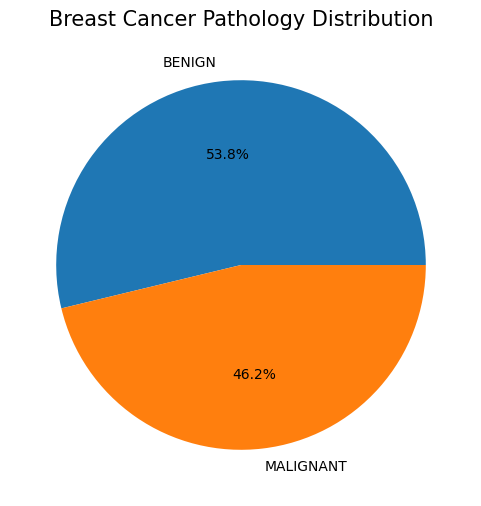

In [20]:
# Pathology distribution
value = mass_df['pathology'].value_counts()
plt.figure(figsize=(6,6))

plt.pie(value, labels=value.index, autopct='%1.1f%%')
plt.title('Breast Cancer Pathology Distribution', fontsize=15)
plt.show()

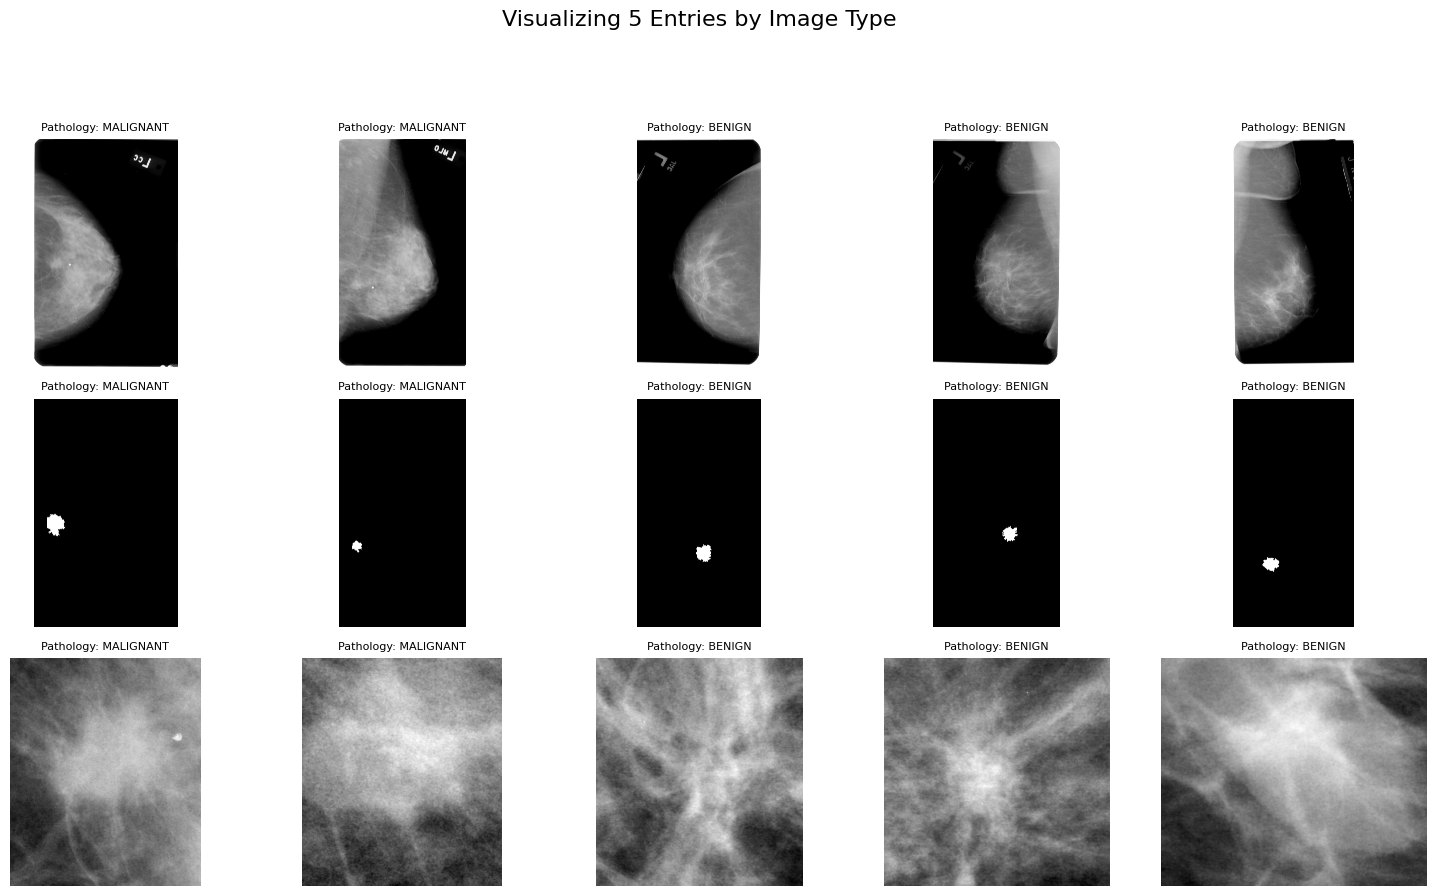

In [21]:
def display_images_by_type(dataframe, num_images_to_show=5):
    image_info = [
        {'column': 'image_file_path', 'title': 'Full Mammogram'},
        {'column': 'ROI_mask_file_path', 'title': 'Mask'},
        {'column': 'cropped_image_file_path', 'title': 'Cropped Mammogram'},
    ]

    num_image_types = len(image_info)
    fig, axes = plt.subplots(num_image_types, num_images_to_show, figsize=(num_images_to_show * 3, num_image_types * 3))
    top_n_entries = dataframe.head(num_images_to_show)

    for type_idx, info in enumerate(image_info):
        column_name = info['column']
        column_title = info['title']
        if type_idx == 0:
            fig.suptitle(f'Visualizing {num_images_to_show} Entries by Image Type', fontsize=16, y=1.02)

        for img_idx, (index, row_data) in enumerate(top_n_entries.iterrows()):
            image_path = row_data[column_name]
            image = mpimg.imread(image_path)

            ax = axes[type_idx][img_idx]
            ax.imshow(image, cmap='gray')

            if img_idx == 0:
                ax.set_ylabel(column_title, rotation=90, size='large', ha='right')
                ax.yaxis.set_label_coords(-0.25, 0.5)

            ax.set_title(f"Pathology: {row_data['pathology']}", fontsize=8)
            ax.axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


display_images_by_type(mass_df, num_images_to_show=5)

# Preprocessing of Images

In [22]:
df = mass_df[['cropped_image_file_path', 'pathology']].copy()
df = df.dropna()  # Drop rows with missing paths or labels

# Split into train and test/validation
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['pathology'], random_state=12)

# Split into test and validation sets (10% of data each)
train_df, valid_df = train_test_split(train_df, test_size=0.5, stratify=train_df['pathology'], random_state=12)

In [23]:
# Define image dimensions and batch size
IMAGE_DIMENSIONS = (224, 224)
TRAINING_BATCH_SIZE = 32

# Basic Augmentation Pipeline
augmentation = ImageDataGenerator(
    rescale=1./255,
    rotation_range=5,
    width_shift_range=0.03,
    height_shift_range=0.03,
    shear_range=0.03,
    zoom_range=0.03,
    fill_mode='reflect',
    horizontal_flip=True,
    vertical_flip=True,
)

# Data generator for training data with augmentation
augmented_train = augmentation.flow_from_dataframe(
    dataframe=train_df,
    x_col='cropped_image_file_path',
    y_col='pathology',
    target_size=IMAGE_DIMENSIONS,
    batch_size=TRAINING_BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=12
)

# Data generators for validation and test data without augmentation (only rescaling)
validation_test_preprocessing = ImageDataGenerator(rescale=1./255)

augmented_validation = validation_test_preprocessing.flow_from_dataframe(
    dataframe=valid_df,
    x_col='cropped_image_file_path',
    y_col='pathology',
    target_size=IMAGE_DIMENSIONS,
    batch_size=TRAINING_BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,
    seed=12
)

augmented_test = validation_test_preprocessing.flow_from_dataframe(
    dataframe=test_df,
    x_col='cropped_image_file_path',
    y_col='pathology',
    target_size=IMAGE_DIMENSIONS,
    batch_size=TRAINING_BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,
    seed=42
)

Found 678 validated image filenames belonging to 2 classes.
Found 678 validated image filenames belonging to 2 classes.
Found 340 validated image filenames belonging to 2 classes.


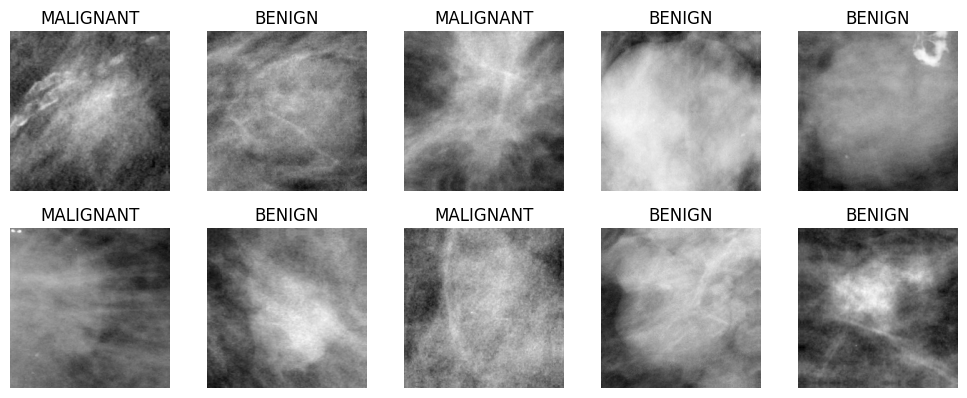

In [24]:
# Get images
images, labels = next(augmented_train)

# Convert labels to names from binary
class_indices = augmented_train.class_indices
classes = list(class_indices.keys())
label_names = [classes[np.argmax(label)] for label in labels]

# Display the images
plt.figure(figsize=(10, 10))
for i in range(min(images.shape[0], 10)): # display 10
    plt.subplot(5, 5, i + 1)
    plt.imshow(images[i])
    plt.title(label_names[i])
    plt.axis('off')
plt.tight_layout()
plt.show()

# CNN Architecture

In [25]:
def create_model(train_set):
    img_shape = (int(224), int(224), int(3)) # has to be 3 channel for pretrained models
    class_count = len(train_set.class_indices)
    print("Class count:", class_count)
    print("Class indices:", train_set.class_indices)

    base_model = DenseNet121(include_top=False, input_shape=img_shape, weights="imagenet")

    # Fine-tune strategy: keep lower layers frozen, train higher-level layers
    for layer in base_model.layers[:80]:
        layer.trainable = False
    for layer in base_model.layers[80:]:
        layer.trainable = True

    # Global feature pooling
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)

    # Dense head with progressive reduction + strong regularization
    x = Dense(1024, activation="relu", kernel_regularizer=l2(1e-4))(x)
    x = Dropout(0.5)(x)
    x = BatchNormalization()(x)

    x = Dense(256, activation="relu", kernel_regularizer=l2(1e-4))(x)
    x = Dropout(0.4)(x)
    x = BatchNormalization()(x)

    x = Dense(64, activation="relu", kernel_regularizer=l2(1e-4))(x)
    x = Dropout(0.3)(x)
    x = BatchNormalization()(x)

    # Output for binary classification
    output = Dense(class_count, activation="sigmoid", name="output_sigmoid")(x)

    # Final model
    model = Model(inputs=base_model.input, outputs=output)

    # Optimizer with slightly lower LR for fine-tuning
    optimizer = Adam(learning_rate=5e-5)

    model.compile(
        optimizer=optimizer,
        loss="binary_crossentropy",
        metrics=[
            "accuracy",
            tf.keras.metrics.AUC(name="auc"),
            tf.keras.metrics.Precision(name="precision"),
            tf.keras.metrics.Recall(name="recall")
        ]
    )

    model.summary()
    return model

model = create_model(augmented_train)

Class count: 2
Class indices: {'BENIGN': 0, 'MALIGNANT': 1}


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 7,717,634 (29.44 MB)

 Trainable params: 6,825,602 (26.04 MB)

 Non-trainable params: 892,032 (3.40 MB)

In [26]:
# Define callbacks
early_stop = EarlyStopping(
    monitor="val_auc",
    mode="max",
    patience=10,
    restore_best_weights=True # rollback to best model
)

reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.3,
    patience=5,
    min_lr=1e-6
)

checkpoint = ModelCheckpoint(
    "best_densenet_cbis.keras",  # save best model
    monitor="val_auc",
    mode="max",
    save_best_only=True,
    verbose=1
)

callbacks = [early_stop, reduce_lr, checkpoint]

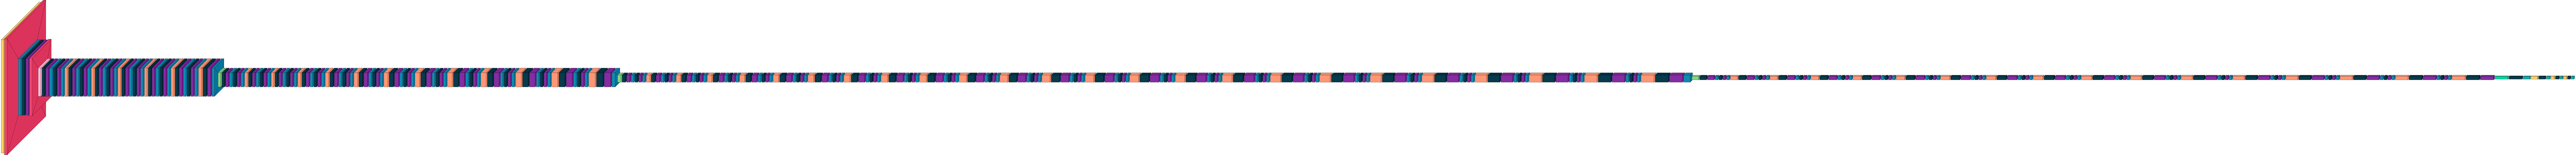

In [27]:
vk.layered_view(
    model
)

In [28]:
def train_and_evaluate_model(model, train_generator, validation_generator, test_generator, num_epochs=60):
    # Model Training
    training_history = model.fit(
        train_generator,
        validation_data=validation_generator,
        epochs=num_epochs,
        callbacks=callbacks,
    )

    # Evaluate Model on Test Set
    test_predictions_probabilities = model.predict(test_generator)
    predicted_class_labels = np.argmax(test_predictions_probabilities, axis=1)
    true_class_labels = test_generator.classes

    # Calculate precision, recall, and F1 score.
    precision_score, recall_score, f1_score, _ = precision_recall_fscore_support(
        true_class_labels, predicted_class_labels, average='weighted', zero_division=0
    )

    # Calculate accuracy and auc
    loss, accuracy, auc, precision, recall = model.evaluate(test_generator, verbose=0)

    # Create metrics dict
    metrics = {
        'test_accuracy': accuracy,
        'test_loss': loss,
        'test_precision': precision,
        'test_recall': recall,
        'test_f1_score': f1_score,
        'test_auc': auc,
    }


    return training_history, metrics

history, metrics = train_and_evaluate_model(model, augmented_train, augmented_validation, augmented_test)

Epoch 1/60
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.5413 - auc: 0.5307 - loss: 1.9947 - precision: 0.5271 - recall: 0.5270
Epoch 1: val_auc improved from -inf to 0.51666, saving model to best_densenet_cbis.keras
22/22 ━━━━━━━━━━━━━━━━━━━━ 306s 7s/step - accuracy: 0.5406 - auc: 0.5302 - loss: 1.9951 - precision: 0.5271 - recall: 0.5268 - val_accuracy: 0.4794 - val_auc: 0.5167 - val_loss: 1.8098 - val_precision: 0.5054 - val_recall: 0.4808 - learning_rate: 1.0000e-04
Epoch 2/60
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step - accuracy: 0.5140 - auc: 0.4935 - loss: 2.0014 - precision: 0.4962 - recall: 0.4763
Epoch 2: val_auc improved from 0.51666 to 0.58463, saving model to best_densenet_cbis.keras
22/22 ━━━━━━━━━━━━━━━━━━━━ 15s 667ms/step - accuracy: 0.5148 - auc: 0.4948 - loss: 1.9998 - precision: 0.4972 - recall: 0.4776 - val_accuracy: 0.5885 - val_auc: 0.5846 - val_loss: 1.7817 - val_precision: 0.5692 - val_recall: 0.4307 - learning_rate: 1.0000e-04
Epoch 3/60
22/22 ━━━━━━━━━━━━━

# Evaluation

In [29]:
print(metrics)

{'test_accuracy': 0.720588207244873, 'test_loss': 1.5085973739624023, 'test_precision': 0.7483870983123779, 'test_recall': 0.6823529601097107, 'test_f1_score': 0.7200245853596393, 'test_auc': 0.8103892803192139}


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step


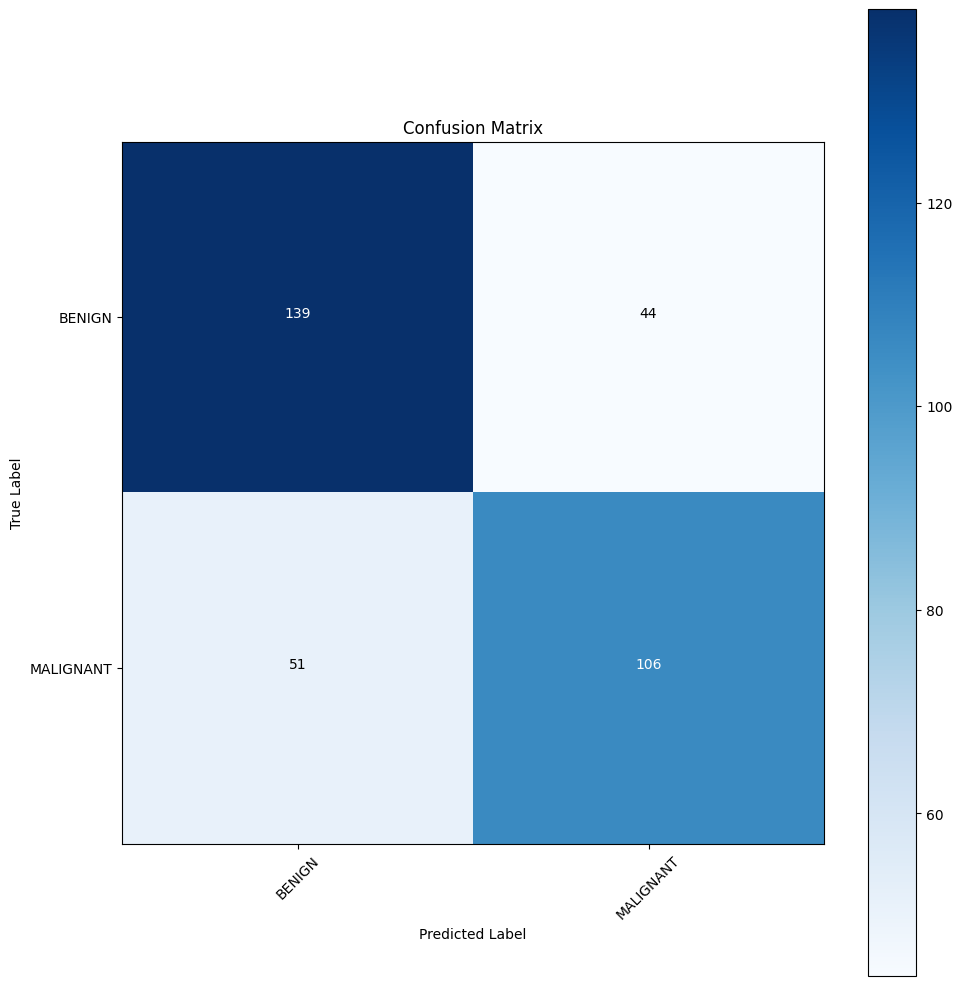

In [30]:
def confusion_matrix_plot(test, y_predict):
  y_pred = np.argmax(y_predict, axis=1)

  # get class indices and labels
  class_indices = test.class_indices
  classes = list(class_indices.keys())

  # compute confusion matrix
  cm = confusion_matrix(test.classes, y_pred)

  plt.figure(figsize=(10, 10))
  plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
  plt.title('Confusion Matrix')
  plt.colorbar()

  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  threshold = cm.max() / 2.0
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(
          j, i, f"{cm[i, j]}",
          horizontalalignment='center',
          color='white' if cm[i, j] > threshold else 'black'
      )

  plt.tight_layout()
  plt.ylabel('True Label')
  plt.xlabel('Predicted Label')
  plt.show()

y_prediction = model.predict(augmented_test)
confusion_matrix_plot(augmented_test, y_prediction)

AUC: 0.8114


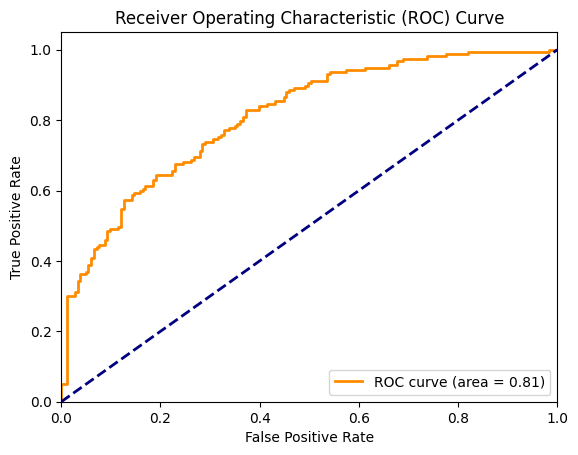

In [31]:
# Get the true labels and predicted probabilities for the positive class (MALIGNANT)
y_true = augmented_test.classes
y_pred_prob = y_prediction[:, 1]  # Get probabilities for the 'MALIGNANT' class

# Calculate the AUC
auc_score = auc(roc_curve(y_true, y_pred_prob)[0], roc_curve(y_true, y_pred_prob)[1])
print(f'AUC: {auc_score:.4f}')

# Plot the ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc_score)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Classification Report

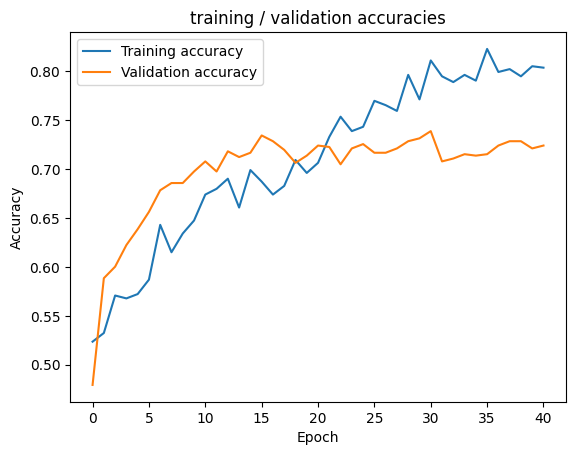

In [32]:
# Visualize model history
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('training / validation accuracies')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc="upper left")
plt.show()

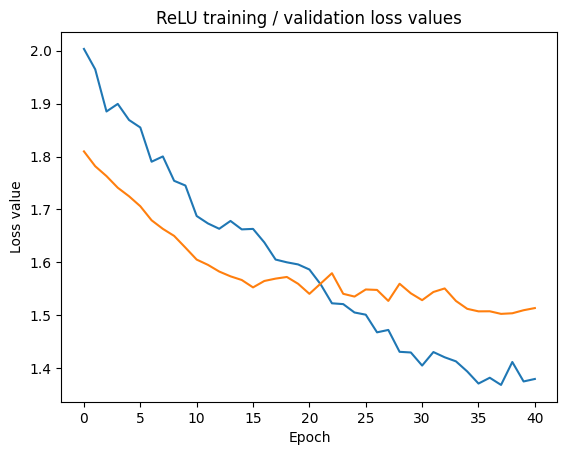

In [33]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('ReLU training / validation loss values')
plt.ylabel('Loss value')
plt.xlabel('Epoch')
plt.show()